In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import naive_bayes
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from graphviz import Source
from IPython.display import SVG
from IPython.display import display
from pydot import graph_from_dot_data
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read in CSV file
data = pd.read_csv("data.csv").dropna()
data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,6,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,4860406,2011,10,6,16,2,1,04,01,1,...,01,01,2003,01,M,24,11,1,02,1
1,4860407,2011,10,6,16,2,1,04,01,1,...,01,01,2003,02,M,09,31,2,02,2
2,4860408,2011,10,6,16,2,1,04,01,1,...,01,01,2003,03,F,07,22,2,02,2
3,4860409,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,01,M,50,11,1,02,1
4,4860410,2011,10,6,14,2,2,UU,UU,1,...,01,01,2007,02,M,15,13,1,02,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,5860401,2014,UU,U,UU,2,UU,UU,01,U,...,13,07,UUUU,01,M,24,11,1,NN,1
999996,5860402,2014,UU,U,23,2,01,06,05,1,...,1,14,2006,01,M,29,96,2,09,5
999997,5860403,2014,UU,U,14,2,01,02,01,1,...,1,01,2006,01,F,UU,11,2,01,1
999998,5860404,2014,UU,U,22,1,01,06,01,2,...,1,22,UUUU,01,M,67,12,3,01,U


# Data Cleaning and Dimensionality Reduction (Binning)

In [3]:
# Data cleaning: P_ISEV
data = data[data['P_ISEV'] != "N"]
data = data[data['P_ISEV'] != "U"]
data = data[data['P_ISEV'] != "X"]
data['P_ISEV'] = pd.to_numeric(data.P_ISEV)
data.loc[(data.P_ISEV == 1),'P_ISEV'] = 0
data.loc[(data.P_ISEV == 2),'P_ISEV'] = 1
data.loc[(data.P_ISEV == 3),'P_ISEV'] = 1
data['P_ISEV'] = pd.Categorical(data.P_ISEV)
data['P_ISEV'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [4]:
# Data cleaning: C_YEAR
data.C_YEAR = pd.Categorical(pd.to_numeric(data.C_YEAR))
data['C_YEAR'].unique()

[2011, 2012, 2013, 2014]
Categories (4, int64): [2011, 2012, 2013, 2014]

In [5]:
# Data cleaning: C_MNTH
data = data[data['C_MNTH'] != "UU"]
data = data[data['C_MNTH'] != "XX"]
data.C_MNTH = pd.Categorical(pd.to_numeric(data.C_MNTH))
data['C_MNTH'].unique()

[10, 11, 12, 1, 2, ..., 5, 6, 7, 8, 9]
Length: 12
Categories (12, int64): [10, 11, 12, 1, ..., 6, 7, 8, 9]

In [6]:
# Data cleaning: C_WDAY
data = data[data['C_WDAY'] != "U"] 
data = data[data['C_WDAY'] != "X"] 
data.C_WDAY = pd.Categorical(pd.to_numeric(data.C_WDAY))
data['C_WDAY'].unique()

[6, 7, 1, 2, 3, 4, 5]
Categories (7, int64): [6, 7, 1, 2, 3, 4, 5]

In [7]:
# Data cleaning: C_HOUR
data = data[data['C_HOUR'] != "UU"]
data = data[data['C_HOUR'] != "XX"]
# Make colliosn hour group categories
data['C_HOUR'] = pd.to_numeric(data['C_HOUR'])
data['C_HOUR'] = pd.cut(data['C_HOUR'], bins=[0,3,6,9,12,15,18,21,23,float('inf')], right=False)
data['C_HOUR'].unique()

[[15.0, 18.0), [12.0, 15.0), [18.0, 21.0), [9.0, 12.0), [3.0, 6.0), [0.0, 3.0), [6.0, 9.0), [21.0, 23.0), [23.0, inf)]
Categories (9, interval[float64]): [[0.0, 3.0) < [3.0, 6.0) < [6.0, 9.0) < [9.0, 12.0) ... [15.0, 18.0) < [18.0, 21.0) < [21.0, 23.0) < [23.0, inf)]

In [8]:
# Data cleaning: C_VEHS
data = data[data['C_VEHS'] != "UU"]
data = data[data['C_VEHS'] != "XX"]
# Make vehicle collided group categories rather than usuing indidvidual number of cars in collision
data['C_VEHS'] = pd.to_numeric(data['C_VEHS'])
data['C_VEHS'] = pd.cut(data['C_VEHS'], bins=[1,5,26,float('inf')], right=False)
data['C_VEHS'].unique()

[[1.0, 5.0), [5.0, 26.0), [26.0, inf)]
Categories (3, interval[float64]): [[1.0, 5.0) < [5.0, 26.0) < [26.0, inf)]

In [9]:
# Data cleaning: C_CONF
data = data[data['C_CONF'] != "QQ"]
data = data[data['C_CONF'] != "UU"]
data = data[data['C_CONF'] != "XX"]
data['C_CONF'] = pd.to_numeric(data['C_CONF'])
data['C_CONF'] = pd.cut(data['C_CONF'], bins=[1,21,31,float('inf')], right=False)
data['C_CONF'].unique()

[[1.0, 21.0), [31.0, inf), [21.0, 31.0)]
Categories (3, interval[float64]): [[1.0, 21.0) < [21.0, 31.0) < [31.0, inf)]

In [10]:
# Data cleaning: C_RCFG
data = data[data['C_RCFG'] != "QQ"]
data = data[data['C_RCFG'] != "UU"] 
data = data[data['C_RCFG'] != "XX"]
data.C_RCFG = pd.Categorical(pd.to_numeric(data.C_RCFG))
data['C_RCFG'].unique()

[1, 2, 4, 3, 5, 8, 6, 9, 7, 10]
Categories (10, int64): [1, 2, 4, 3, ..., 6, 9, 7, 10]

In [11]:
# Data cleaning: C_WTHR
data = data[data['C_WTHR'] !=  "Q"]
data = data[data['C_WTHR'] !=  "U"]
data = data[data['C_WTHR'] !=  "X"]
data.C_WTHR = pd.Categorical(pd.to_numeric(data.C_WTHR))
data['C_WTHR'].unique()

[1, 3, 4, 2, 7, 6, 5]
Categories (7, int64): [1, 3, 4, 2, 7, 6, 5]

In [12]:
# Data cleaning: C_RSUR
data = data[data['C_RSUR'] !=  "Q"]
data = data[data['C_RSUR'] !=  "U"]
data = data[data['C_RSUR'] !=  "X"]
data.C_RSUR = pd.Categorical(pd.to_numeric(data.C_RSUR))
data['C_RSUR'].unique()

[1, 2, 5, 3, 9, 6, 8, 4, 7]
Categories (9, int64): [1, 2, 5, 3, ..., 6, 8, 4, 7]

In [13]:
# Data cleaning: C_RALN 
data = data[data['C_RALN'] != "Q"] 
data = data[data['C_RALN'] != "U"] 
data = data[data['C_RALN'] != "X"]
data.C_RALN = pd.Categorical(pd.to_numeric(data.C_RALN))
data['C_RALN'].unique()

[1, 4, 3, 5, 2, 6]
Categories (6, int64): [1, 4, 3, 5, 2, 6]

In [14]:
# Data cleaning: C_TRAF 
data = data[data['C_TRAF'] != "QQ"]
data = data[data['C_TRAF'] != "UU"]
data = data[data['C_TRAF'] != "XX"]
data['C_TRAF'] = pd.to_numeric(data['C_TRAF'])
data['C_TRAF'] = pd.cut(data['C_TRAF'], bins=[1,3,8,10,13,15,17,18,float('inf')], right=False)
data['C_TRAF'].unique()

[[18.0, inf), [3.0, 8.0), [1.0, 3.0), [10.0, 13.0), [13.0, 15.0), [8.0, 10.0), [15.0, 17.0), [17.0, 18.0)]
Categories (8, interval[float64]): [[1.0, 3.0) < [3.0, 8.0) < [8.0, 10.0) < [10.0, 13.0) < [13.0, 15.0) < [15.0, 17.0) < [17.0, 18.0) < [18.0, inf)]

In [15]:
# Data cleaning: V_TYPE
data = data[data['V_TYPE'] != "QQ"] 
data = data[data['V_TYPE'] != "UU"] 
data = data[data['V_TYPE'] != "NN"] 
data['V_TYPE'] = pd.to_numeric(data['V_TYPE'])
data['V_TYPE'] = pd.cut(data['V_TYPE'], bins=[0,5,8,9,float('inf')], right=False)
data['V_TYPE'].unique()

[[0.0, 5.0), [9.0, inf), [8.0, 9.0), [5.0, 8.0)]
Categories (4, interval[float64]): [[0.0, 5.0) < [5.0, 8.0) < [8.0, 9.0) < [9.0, inf)]

In [16]:
# Data cleaning: V_YEAR
data = data[data['V_YEAR'] != "NNNN"] 
data = data[data['V_YEAR'] != "UUUU"] 
data = data[data['V_YEAR'] != "QQQQ"]
# Make vehicle year group categories rather than using indidvidual years
data['V_YEAR'] = pd.to_numeric(data['V_YEAR'])
data['V_YEAR'] = pd.cut(data['V_YEAR'], bins=[1900,1950,1980,1990,2000,2010,float('inf')], right=False)
data['V_YEAR'].unique()

[[2000.0, 2010.0), [2010.0, inf), [1990.0, 2000.0), [1980.0, 1990.0), [1950.0, 1980.0), [1900.0, 1950.0)]
Categories (6, interval[float64]): [[1900.0, 1950.0) < [1950.0, 1980.0) < [1980.0, 1990.0) < [1990.0, 2000.0) < [2000.0, 2010.0) < [2010.0, inf)]

In [17]:
# Data cleaning: P_SEX
data = data[data['P_SEX'] != "N"]
data = data[data['P_SEX'] != "U"] 
data.P_SEX = pd.Categorical(data.P_SEX)
data['P_SEX'].unique()

[M, F]
Categories (2, object): [M, F]

In [18]:
# Data cleaning: P_AGE
data = data[data['P_AGE'] != "NN"]
data = data[data['P_AGE'] != "UU"]
data = data[data['P_AGE'] != "XX"]
# Make age-group categories rather than usuing indidvidual ages
data['P_AGE'] = pd.to_numeric(data['P_AGE'])
data['P_AGE'] = pd.cut(data['P_AGE'], bins=[0,10,20,30,40,50,60,70,80,90,float('inf')], right=False)
data['P_AGE'].unique()  

[[20.0, 30.0), [0.0, 10.0), [60.0, 70.0), [40.0, 50.0), [10.0, 20.0), [70.0, 80.0), [80.0, 90.0), [50.0, 60.0), [30.0, 40.0), [90.0, inf)]
Categories (10, interval[float64]): [[0.0, 10.0) < [10.0, 20.0) < [20.0, 30.0) < [30.0, 40.0) ... [60.0, 70.0) < [70.0, 80.0) < [80.0, 90.0) < [90.0, inf)]

In [19]:
# Data cleaning: P_PSN
data = data[data['P_PSN'] != "NN"]
data = data[data['P_PSN'] != "QQ"]
data = data[data['P_PSN'] != "UU"]
data = data[data['P_PSN'] != "XX"]
# Make person position categories
data['P_PSN'] = pd.to_numeric(data['P_PSN'])

# 96 is position unknown so get rid of rows with this
data = data[data['P_PSN'] != 96]
data['P_PSN'] = pd.cut(data['P_PSN'], bins=[11,21,31,34,98,99,float('inf')], right=False)
data['P_PSN'].unique()

[[11.0, 21.0), [31.0, 34.0), [21.0, 31.0), [98.0, 99.0), [34.0, 98.0)]
Categories (5, interval[float64]): [[11.0, 21.0) < [21.0, 31.0) < [31.0, 34.0) < [34.0, 98.0) < [98.0, 99.0)]

In [20]:
# Data cleaning: P_SAFE
data = data[data['P_SAFE'] != "NN"]
data = data[data['P_SAFE'] != "QQ"]
data = data[data['P_SAFE'] != "UU"]
data = data[data['P_SAFE'] != "XX"]
data.P_SAFE = pd.Categorical(pd.to_numeric(data.P_SAFE))
data['P_SAFE'].unique()  

[2, 1, 9, 13, 12, 10, 11]
Categories (7, int64): [2, 1, 9, 13, 12, 10, 11]

In [21]:
# Data cleaning: P_USER
data = data[data['P_USER'] != "U"] 
data.P_USER = pd.Categorical(pd.to_numeric(data.P_USER))
data['P_USER'].unique()  

[1, 2, 5, 4]
Categories (4, int64): [1, 2, 5, 4]

# Data Exploration

In [22]:
data['P_ISEV'].value_counts()

1    314346
0    245002
Name: P_ISEV, dtype: int64

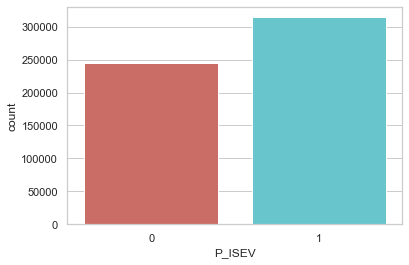

In [23]:
sns.countplot(x='P_ISEV', data=data, palette='hls')
plt.rcParams["figure.figsize"] = [12,5]
plt.show()

In [24]:
data['C_YEAR'].value_counts()

2012    180168
2013    178941
2014    165375
2011     34864
Name: C_YEAR, dtype: int64

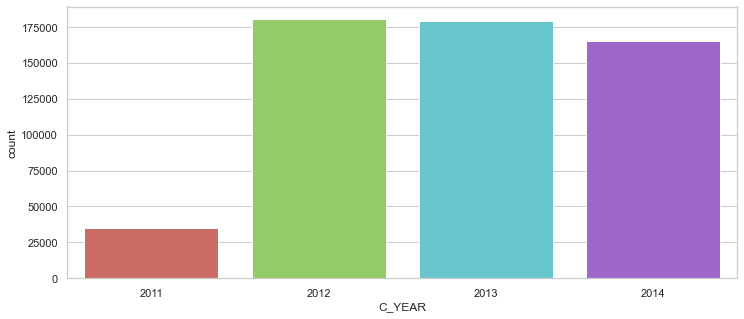

In [25]:
sns.countplot(x='C_YEAR', data=data, palette='hls')
plt.show()

In [26]:
data['C_MNTH'].value_counts()

12    60710
11    60444
10    51061
8     48805
7     48313
9     46792
6     45883
1     45386
5     42674
2     38278
3     36725
4     34277
Name: C_MNTH, dtype: int64

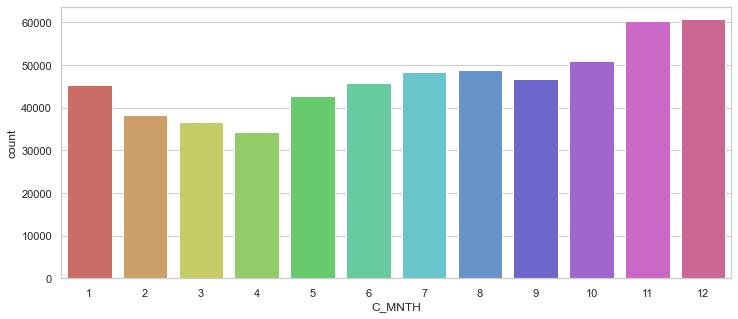

In [27]:
sns.countplot(x='C_MNTH', data=data, palette='hls')
plt.show()

In [28]:
data['C_WDAY'].value_counts()

5    95259
4    85286
6    79738
3    79565
2    79213
1    74237
7    66050
Name: C_WDAY, dtype: int64

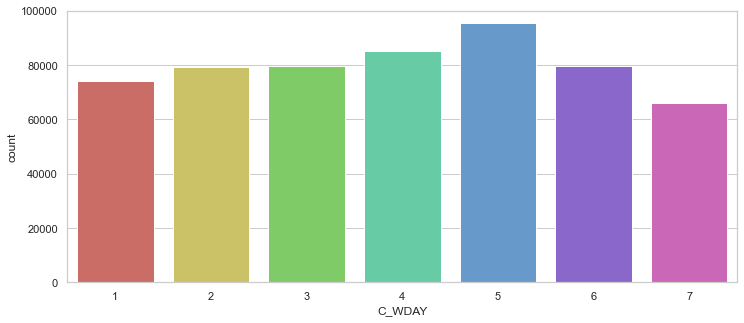

In [29]:
sns.countplot(x='C_WDAY', data=data, palette='hls')
plt.show()

In [30]:
data['C_HOUR'].value_counts()

[15.0, 18.0)    153215
[12.0, 15.0)    110636
[18.0, 21.0)     81906
[9.0, 12.0)      80144
[6.0, 9.0)       64625
[21.0, 23.0)     30359
[0.0, 3.0)       16528
[3.0, 6.0)       12280
[23.0, inf)       9655
Name: C_HOUR, dtype: int64

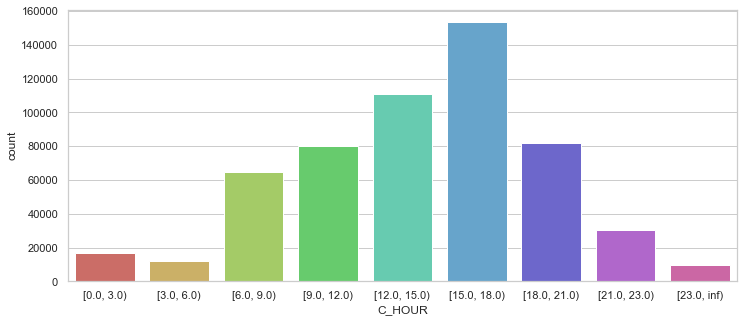

In [31]:
sns.countplot(x='C_HOUR', data=data, palette='hls')
plt.show()

In [32]:
data['C_VEHS'].value_counts()

[1.0, 5.0)     551665
[5.0, 26.0)      7441
[26.0, inf)       242
Name: C_VEHS, dtype: int64

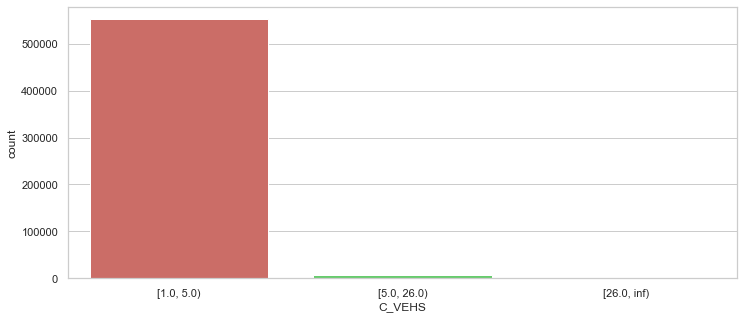

In [33]:
sns.countplot(x='C_VEHS', data=data, palette='hls')
plt.show()

In [34]:
data['C_CONF'].value_counts()

[21.0, 31.0)    234181
[31.0, inf)     222824
[1.0, 21.0)     102343
Name: C_CONF, dtype: int64

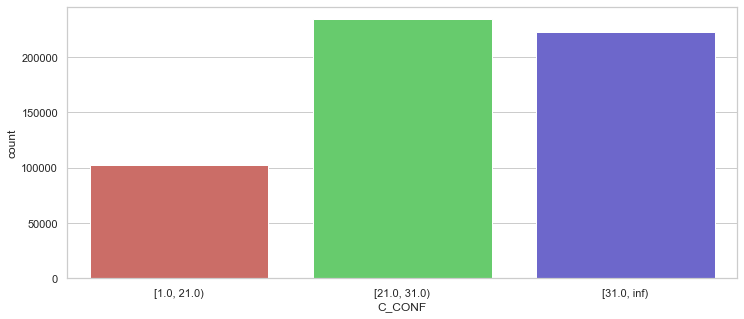

In [35]:
sns.countplot(x='C_CONF', data=data, palette='hls')
plt.show()

In [36]:
data['C_RCFG'].value_counts()

2     290706
1     230455
3      28568
5       5335
4       1527
8       1213
6        855
9        521
10       112
7         56
Name: C_RCFG, dtype: int64

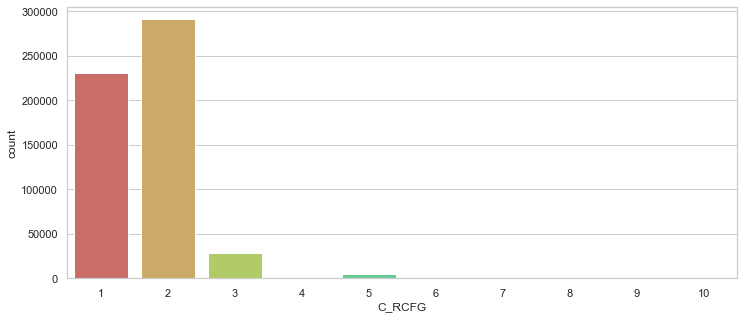

In [37]:
sns.countplot(x='C_RCFG', data=data, palette='hls')
plt.show()

In [38]:
data['C_WTHR'].value_counts()

1    401194
3     58952
2     50777
4     34477
6      9251
5      3007
7      1690
Name: C_WTHR, dtype: int64

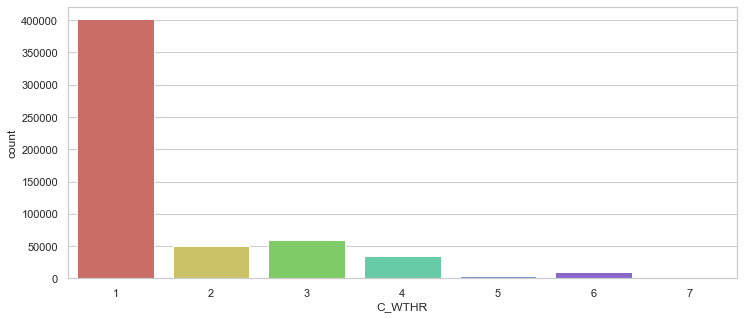

In [39]:
sns.countplot(x='C_WTHR', data=data, palette='hls')
plt.show()

In [40]:
data['C_RSUR'].value_counts()

1    380311
2    107833
5     34748
3     23980
4      9732
6      2196
7       391
8       124
9        33
Name: C_RSUR, dtype: int64

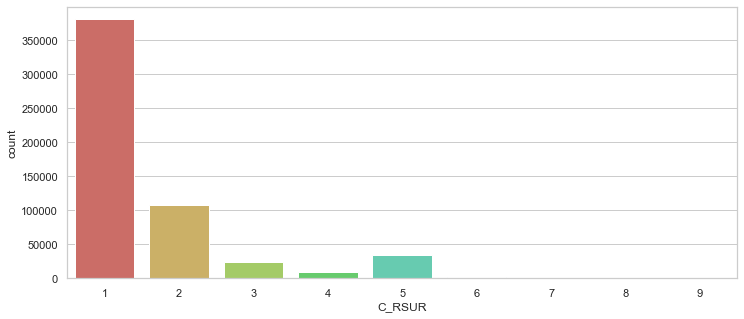

In [41]:
sns.countplot(x='C_RSUR', data=data, palette='hls')
plt.show()

In [42]:
data['C_RALN'].value_counts()

1    442924
2     53847
3     33352
4     18238
5      6189
6      4798
Name: C_RALN, dtype: int64

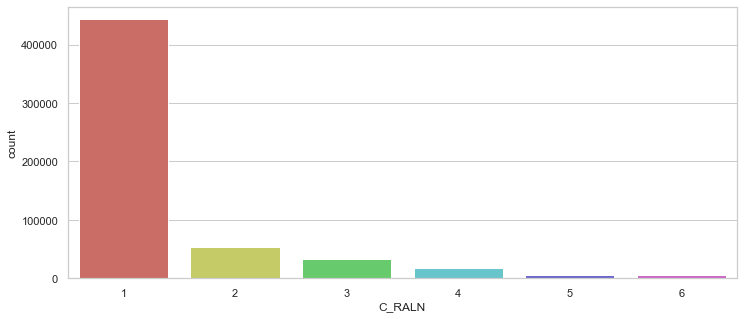

In [43]:
sns.countplot(x='C_RALN', data=data, palette='hls')
plt.show()

In [44]:
data['C_TRAF'].value_counts()

[18.0, inf)     292067
[1.0, 3.0)      184501
[3.0, 8.0)       77582
[8.0, 10.0)       3037
[10.0, 13.0)      1078
[13.0, 15.0)       593
[15.0, 17.0)       423
[17.0, 18.0)        67
Name: C_TRAF, dtype: int64

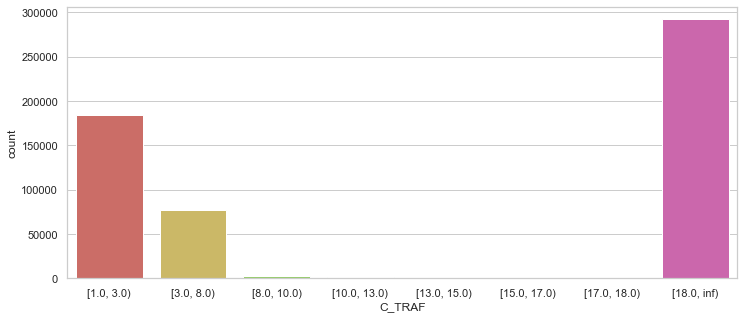

In [45]:
sns.countplot(x='C_TRAF', data=data, palette='hls')
plt.show()

In [46]:
data['V_TYPE'].value_counts()

[0.0, 5.0)    508686
[5.0, 8.0)     24107
[9.0, inf)     20011
[8.0, 9.0)      6544
Name: V_TYPE, dtype: int64

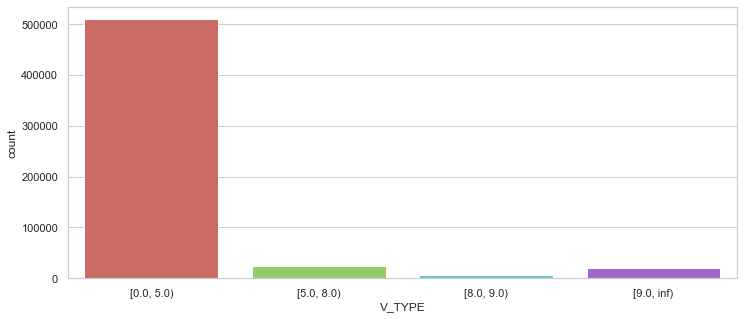

In [47]:
sns.countplot(x='V_TYPE', data=data, palette='hls')
plt.show()

In [48]:
data['V_YEAR'].value_counts()

[2000.0, 2010.0)    351456
[2010.0, inf)       134051
[1990.0, 2000.0)     68597
[1980.0, 1990.0)      4409
[1950.0, 1980.0)       793
[1900.0, 1950.0)        42
Name: V_YEAR, dtype: int64

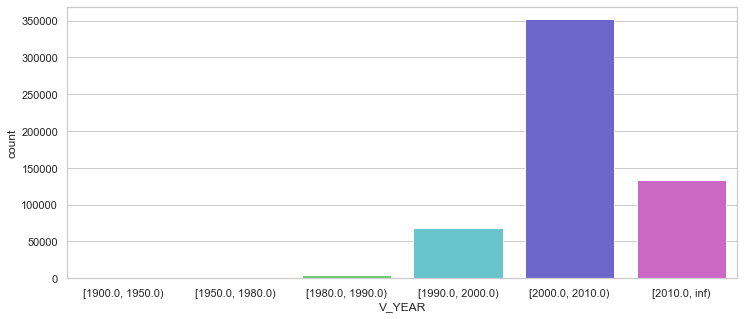

In [49]:
sns.countplot(x='V_YEAR', data=data, palette='hls')
plt.show()

In [50]:
data['P_SEX'].value_counts()

M    294077
F    265271
Name: P_SEX, dtype: int64

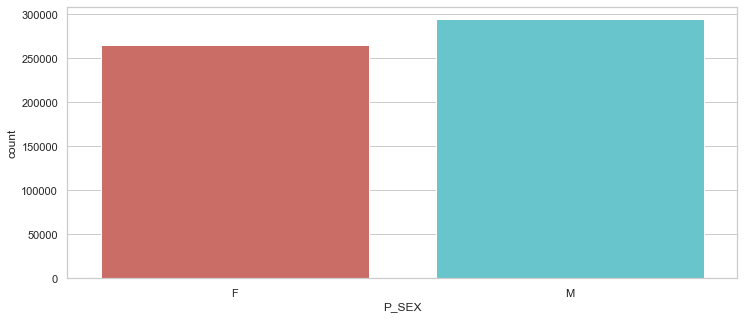

In [51]:
sns.countplot(x='P_SEX', data=data, palette='hls')
plt.show()

In [52]:
data['P_PSN'].value_counts()

[11.0, 21.0)    491971
[21.0, 31.0)     63540
[31.0, 34.0)      3728
[98.0, 99.0)        72
[34.0, 98.0)        37
[99.0, inf)          0
Name: P_PSN, dtype: int64

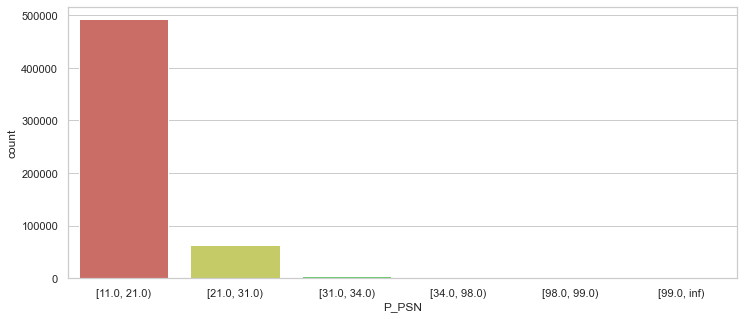

In [53]:
sns.countplot(x='P_PSN', data=data, palette='hls')
plt.show()

In [54]:
data['P_SAFE'].value_counts()

2     527845
9      10416
1      10371
13      6552
12      4162
10         2
11         0
Name: P_SAFE, dtype: int64

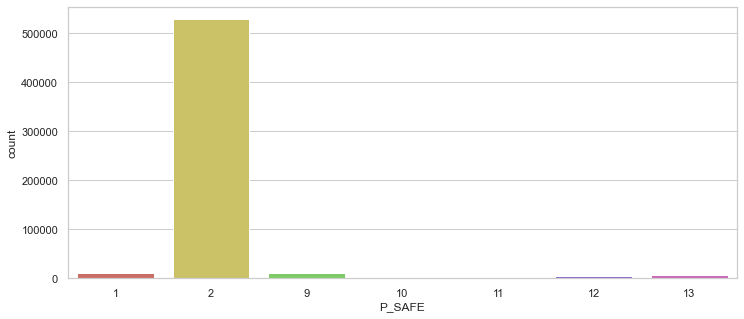

In [55]:
sns.countplot(x='P_SAFE', data=data, palette='hls')
plt.show()

In [56]:
data['P_USER'].value_counts()

1    383086
2    164757
5     10921
4       584
Name: P_USER, dtype: int64

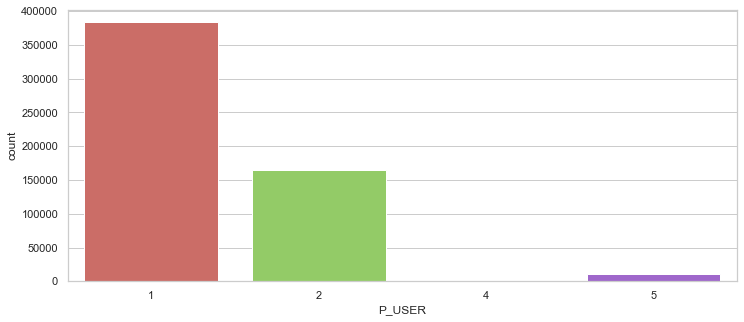

In [57]:
sns.countplot(x='P_USER', data=data, palette='hls')
plt.show()

# Prepare Data for Maching Learning

In [26]:
# Convert data to categorical features (get dummy variables) 
cat_vars=['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF',
         'V_TYPE','V_YEAR','P_SEX','P_AGE','P_PSN','P_SAFE','P_USER']
train = data['P_ISEV']
for var in cat_vars:
    cat_list = pd.get_dummies(data[var], prefix=var, drop_first=True)
    train = pd.concat([train,cat_list],axis=1)

categories = train.drop('P_ISEV',axis=1).columns.values
    
train.columns.values

array(['P_ISEV', 'C_YEAR_2012', 'C_YEAR_2013', 'C_YEAR_2014', 'C_MNTH_2',
       'C_MNTH_3', 'C_MNTH_4', 'C_MNTH_5', 'C_MNTH_6', 'C_MNTH_7',
       'C_MNTH_8', 'C_MNTH_9', 'C_MNTH_10', 'C_MNTH_11', 'C_MNTH_12',
       'C_WDAY_2', 'C_WDAY_3', 'C_WDAY_4', 'C_WDAY_5', 'C_WDAY_6',
       'C_WDAY_7', 'C_HOUR_[3.0, 6.0)', 'C_HOUR_[6.0, 9.0)',
       'C_HOUR_[9.0, 12.0)', 'C_HOUR_[12.0, 15.0)', 'C_HOUR_[15.0, 18.0)',
       'C_HOUR_[18.0, 21.0)', 'C_HOUR_[21.0, 23.0)', 'C_HOUR_[23.0, inf)',
       'C_VEHS_[5.0, 26.0)', 'C_VEHS_[26.0, inf)', 'C_CONF_[21.0, 31.0)',
       'C_CONF_[31.0, inf)', 'C_RCFG_2', 'C_RCFG_3', 'C_RCFG_4',
       'C_RCFG_5', 'C_RCFG_6', 'C_RCFG_7', 'C_RCFG_8', 'C_RCFG_9',
       'C_RCFG_10', 'C_WTHR_2', 'C_WTHR_3', 'C_WTHR_4', 'C_WTHR_5',
       'C_WTHR_6', 'C_WTHR_7', 'C_RSUR_2', 'C_RSUR_3', 'C_RSUR_4',
       'C_RSUR_5', 'C_RSUR_6', 'C_RSUR_7', 'C_RSUR_8', 'C_RSUR_9',
       'C_RALN_2', 'C_RALN_3', 'C_RALN_4', 'C_RALN_5', 'C_RALN_6',
       'C_TRAF_[3.0, 8.0)', 'C_TRAF_

In [33]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train.drop('P_ISEV',axis=1), 
                                                    train['P_ISEV'], test_size=0.30, 
                                                    random_state=101)

# Baseline Model

# Logistic Regression

In [67]:
# Create logistic regression model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [68]:
# Get model coefficients
coefficients = logmodel.coef_[0]
cat_coefs = pd.DataFrame({'category': categories, 'coefficient': coefficients})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cat_coefs)

                   category  coefficient
0               C_YEAR_2012     0.017711
1               C_YEAR_2013     0.026663
2               C_YEAR_2014     0.045501
3                  C_MNTH_2     0.074934
4                  C_MNTH_3     0.156389
5                  C_MNTH_4     0.147130
6                  C_MNTH_5     0.115430
7                  C_MNTH_6     0.082653
8                  C_MNTH_7     0.067718
9                  C_MNTH_8     0.070161
10                 C_MNTH_9     0.106242
11                C_MNTH_10     0.090355
12                C_MNTH_11     0.121257
13                C_MNTH_12     0.038478
14                 C_WDAY_2    -0.019287
15                 C_WDAY_3    -0.036353
16                 C_WDAY_4    -0.059181
17                 C_WDAY_5    -0.063969
18                 C_WDAY_6    -0.110965
19                 C_WDAY_7    -0.087499
20        C_HOUR_[3.0, 6.0)     0.187785
21        C_HOUR_[6.0, 9.0)    -0.340100
22       C_HOUR_[9.0, 12.0)    -0.403495
23      C_HOUR_[

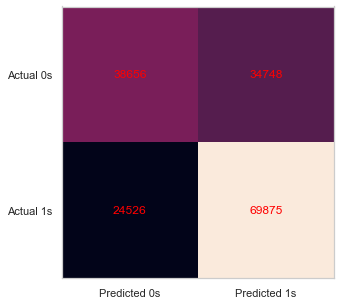

In [69]:
# Create the confusion matrix
cm = confusion_matrix(y_test,predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     73404
           1       0.67      0.74      0.70     94401

    accuracy                           0.65    167805
   macro avg       0.64      0.63      0.63    167805
weighted avg       0.64      0.65      0.64    167805



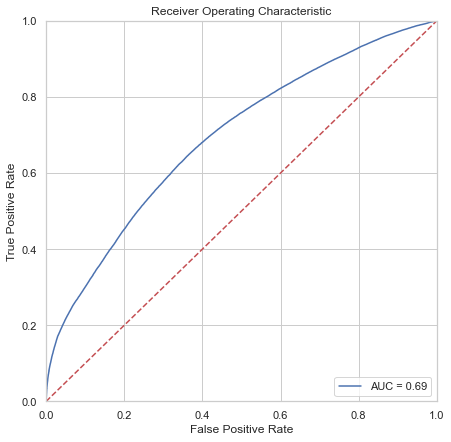

In [72]:
# Evaluate model using the testing data set
print(classification_report(y_test,predictions))

# Create ROC curve and get AUC
probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Neural Network

In [48]:
# Split training set into training and validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, 
                                                    y_train, test_size=0.10, 
                                                    random_state=101)

In [49]:
# Create the neural network
model_nn = models.Sequential()
model_nn.add(layers.Dense(99, input_dim=99, activation='relu'))
model_nn.add(layers.Dense(1, activation='sigmoid'))
model_nn.summary()

model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_nn.fit(X_train_2, y_train_2, epochs=10, 
                    validation_data=(X_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 99)                9900      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 100       
Total params: 10,000
Trainable params: 10,000
Non-trainable params: 0
_________________________________________________________________
Train on 352388 samples, validate on 39155 samples
Epoch 1/10
352388/352388 [==============================] - 24s 67us/sample - loss: 0.6161 - accuracy: 0.6524 - val_loss: 0.6106 - val_accuracy: 0.6564
Epoch 2/10
352388/352388 [==============================] - 23s 65us/sample - loss: 0.6054 - accuracy: 0.6621 - val_loss: 0.6080 - val_accuracy: 0.6589
Epoch 3/10
352388/352388 [==============================] - 22s 63us/sample - loss: 0.6027 - accuracy: 0.6639 - val_loss: 0.6081 - val_accuracy: 0.6588
Epoch

In [84]:
# Get prediction probabilities
preds = model_nn.predict(X_test)

# Get predictions in 1s and 0s
predictions = np.array(preds, copy=True) 
predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

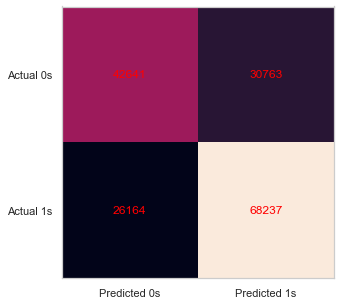

In [72]:
# Create the confusion matrix
cm = confusion_matrix(y_test,predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.58      0.60     73404
           1       0.69      0.72      0.71     94401

    accuracy                           0.66    167805
   macro avg       0.65      0.65      0.65    167805
weighted avg       0.66      0.66      0.66    167805



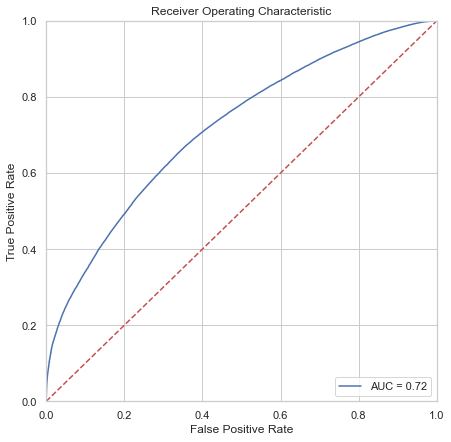

In [87]:
# Evaluate model using the testing data set
print(classification_report(y_test,predictions))

# Create ROC curve and get AUC
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Decision Tree

In [213]:
# Build the decision tree
# Limit the depth to avoid overfitting
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)

[Text(502.20000000000005, 489.24, 'P_SEX_M <= 0.5\ngini = 0.492\nsamples = 391543\nvalue = [171598, 219945]\nclass = 1'),
 Text(251.10000000000002, 380.52000000000004, 'P_PSN_[21.0, 31.0) <= 0.5\ngini = 0.459\nsamples = 185540\nvalue = [66299, 119241]\nclass = 1'),
 Text(125.55000000000001, 271.8, 'C_RSUR_5 <= 0.5\ngini = 0.444\nsamples = 161470\nvalue = [53620, 107850]\nclass = 1'),
 Text(62.775000000000006, 163.08000000000004, 'C_RCFG_2 <= 0.5\ngini = 0.451\nsamples = 150502\nvalue = [51708, 98794]\nclass = 1'),
 Text(31.387500000000003, 54.360000000000014, '\n  (...)  \n'),
 Text(94.16250000000001, 54.360000000000014, '\n  (...)  \n'),
 Text(188.32500000000002, 163.08000000000004, 'C_CONF_[21.0, 31.0) <= 0.5\ngini = 0.288\nsamples = 10968\nvalue = [1912, 9056]\nclass = 1'),
 Text(156.9375, 54.360000000000014, '\n  (...)  \n'),
 Text(219.71250000000003, 54.360000000000014, '\n  (...)  \n'),
 Text(376.65000000000003, 271.8, 'P_SAFE_2 <= 0.5\ngini = 0.499\nsamples = 24070\nvalue = [126

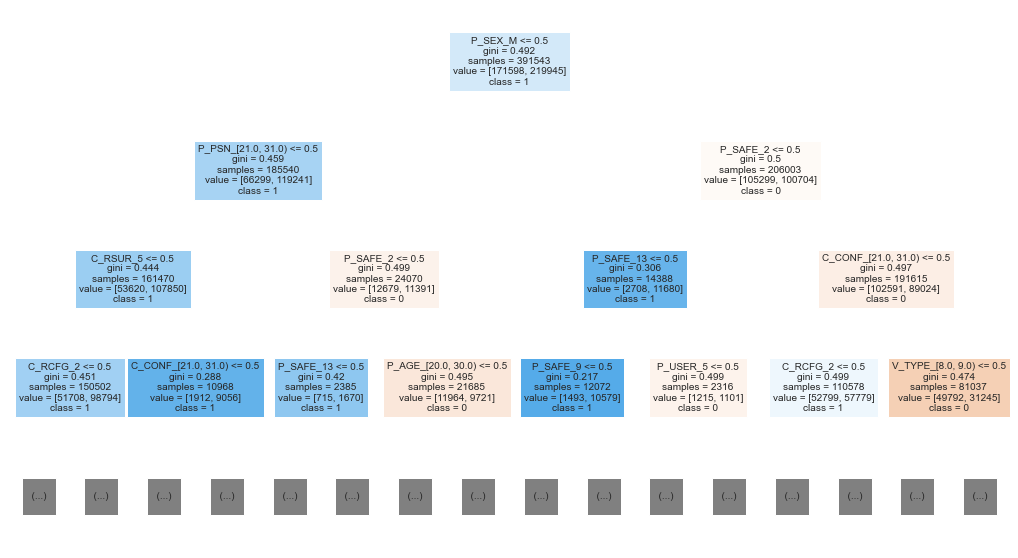

In [217]:
# Visualize the top of the decision tree 
fig, ax = plt.subplots(figsize=(18, 10))
tree.plot_tree(dt,
               feature_names = categories, 
               class_names=['0', '1'],
               max_depth = 3, 
               fontsize=10, 
               filled = True)

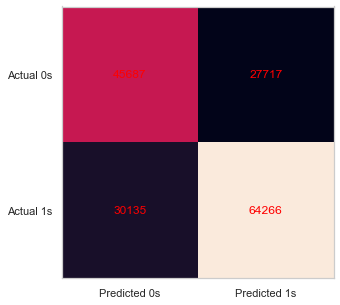

In [215]:
# Create the confusion matrix
cm = confusion_matrix(y_test,predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.60      0.62      0.61     73404
           1       0.70      0.68      0.69     94401

    accuracy                           0.66    167805
   macro avg       0.65      0.65      0.65    167805
weighted avg       0.66      0.66      0.66    167805



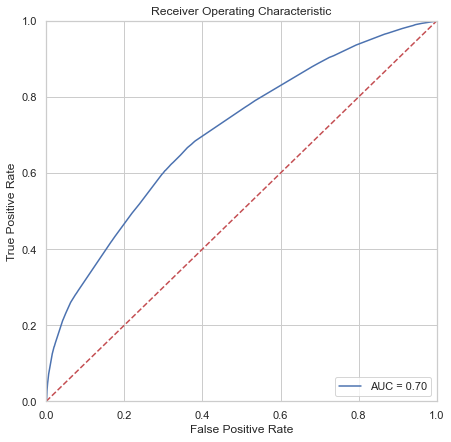

In [216]:
# Evaluate model using the testing data set
print(classification_report(y_test,predictions))

# Create ROC curve and get AUC
probs = dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Naive Bayes

In [45]:
nb = naive_bayes.CategoricalNB()
model_nb = nb.fit(X_train, y_train)
predictions = model_nb.predict(X_test)

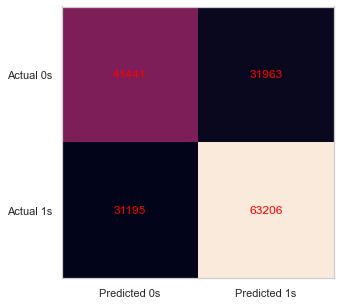

In [46]:
# Create the confusion matrix
cm = confusion_matrix(y_test,predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.56      0.57     73404
           1       0.66      0.67      0.67     94401

    accuracy                           0.62    167805
   macro avg       0.62      0.62      0.62    167805
weighted avg       0.62      0.62      0.62    167805



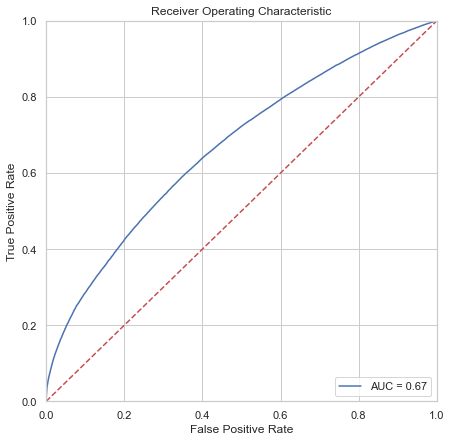

In [47]:
# Evaluate model using the testing data set
print(classification_report(y_test,predictions))

# Create ROC curve and get AUC
probs = model_nb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# k-Nearest Neighbor (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

model.fit(X_train, y_train)

In [ ]:
# Evaluate the model


# SVM

In [ ]:
# Take a subset of data because the whole dataset did finish after running for over 5 hours





svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
# Evaluate the model
